In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, ParameterGrid
import nltk
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
from sklearn import decomposition
import pandas as pd
from copy import deepcopy
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import json
import itertools
import random
import warnings
import string
from shutil import copyfile
warnings.filterwarnings("ignore", category=UserWarning)

from functions import *


In [2]:
global_shuffle_seed = 4
global_debug=True
global_override=True

In [3]:
result, clf_result = {}, {}
df_data = load_data_tagtog(['../tagtog/output'])
df_data = df_data[df_data['is_flood'].notna()]
data_true = query_dataframe(df_data, {'is_flood':True})
data_false = query_dataframe(df_data, {'is_flood':False})
print('Total:',len(df_data),'True:',len(data_true), 'False:',len(data_false))

Total: 1380 True: 663 False: 717


In [4]:
df_data = add_newspapers(df_data)
df_data = add_datePublished(df_data)
df_data = add_location(df_data)

Connect_filename: 1989_34feabf9fb9bd7378a2a378bbc72e5c80ce50f43.txt not found in paper: nytimes None
Connect_filename: 1989_72ea0049403a8352f966af952ce35fdfa4f75880.txt not found in paper: nytimes None
Connect_filename: 1989_3e5fb503a3e12bd28b90e109b828cbd0bdb9cbb7.txt not found in paper: nytimes None
Connect_filename: 1989_ccd0c51c174b4f4c76a6d8c3053f8567f09a4d10.txt not found in paper: nytimes None
Connect_filename: 1985_7f4528fb7fc63a7211fd7403878914dd17917d62.txt not found in paper: nytimes None
Connect_filename: 1989_9588181e3402b6b4a67d9dc7f2d52e030484497d.txt not found in paper: nytimes None
Connect_filename: 1989_ac61d6dde559b3b37b3136319b70d592c62e8557.txt not found in paper: nytimes None
Connect_filename: 1989_50fecf13697bb74d55af74ddb6607fbbbbfe6169.txt not found in paper: nytimes None
Connect_filename: 1989_53f239040243347d84d785d0d168a1879095a5a1.txt not found in paper: nytimes None
Connect_filename: 1985_5b2ccf9aeab018b80c8c877dbd8ea875e6aa4945.txt not found in paper: nyt

In [20]:
custom_stop_words = set(['date', 'published'])
stop_words = set(nltk.corpus.stopwords.words('english'))
punctuations = set(string.punctuation)
all_stop_words = stop_words.union(punctuations, custom_stop_words)
def preprocess(x):
    x = re.sub('[^a-z\s]', ' ', x.lower())
    x = [w for w in x.split() if w not in all_stop_words and len(w)>3]
    return ' '.join(x)

In [21]:
df_data['org_text'] = df_data['text']
df_data['text'] = df_data['text'].apply(preprocess)

## Stats

In [79]:
def runall(func, text, ffunc=None):
    n = [func(f) for f in df_data[text]]
    nif = [func(f) for f in df_data.loc[df_data['is_flood']==True][text]]
    nnf = [func(f) for f in df_data.loc[df_data['is_flood']!=True][text]]
    
    if ffunc is not None:
        n, nif, nnf = ffunc(n), ffunc(nif), ffunc(nnf)
    return n, nif, nnf

In [80]:
# Sentences
def sent_func(f): return len(f.split('.'))
runall(sent_func, 'org_text', ffunc=lambda x: int(np.mean(x)))

(28, 24, 32)

In [81]:
# Standard Deviation
runall(sent_func, 'org_text', ffunc=lambda x: int(np.std(x)))

(26, 15, 32)

In [82]:
# Max
runall(sent_func, 'org_text', ffunc=lambda x: int(np.max(x)))

(263, 119, 263)

In [83]:
# Min
runall(sent_func, 'org_text', ffunc=lambda x: int(np.min(x)))

(1, 1, 1)

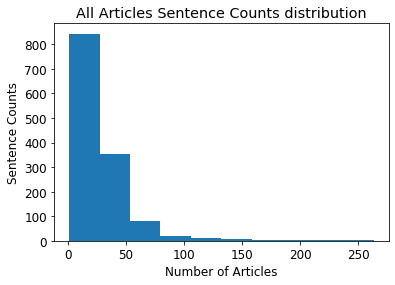

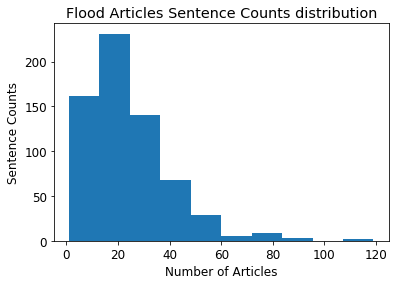

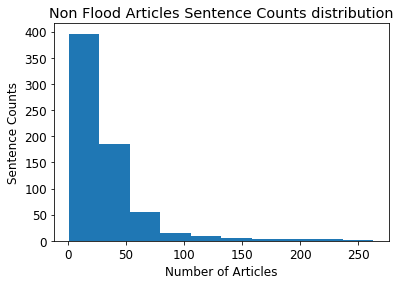

In [90]:
#Hist
n, nif, nnf = runall(sent_func, 'org_text')
plt.hist(n)
plt.title('All Articles Sentence Counts distribution')
plt.xlabel('Number of Articles')
plt.ylabel('Sentence Counts')
plt.show()
plt.hist(nif)
plt.title('Flood Articles Sentence Counts distribution')
plt.xlabel('Number of Articles')
plt.ylabel('Sentence Counts')
plt.show()
plt.hist(nnf)
plt.title('Non Flood Articles Sentence Counts distribution')
plt.xlabel('Number of Articles')
plt.ylabel('Sentence Counts')
plt.show()

In [31]:
# Words, org_text
def words_func(f): return len(f.split(' '))
runall(words_func, 'org_text', ffunc=lambda x: int(np.mean(x)))

(582, 483, 673)

In [32]:
# Words, pre-processed_text
def words_func(f): return len(f.split(' '))
runall(words_func, 'text', ffunc=lambda x: int(np.mean(x)))

(321, 275, 362)

In [33]:
# Words, unique, org_text
def words_func(f): return len(set(f.split(' ')))
runall(words_func, 'org_text', ffunc=lambda x: int(np.mean(x)))

(314, 271, 353)

In [34]:
# Words, unique, pre-processed_text
def words_func(f): return len(set(f.split(' ')))
runall(words_func, 'text', ffunc=lambda x: int(np.mean(x)))

(205, 176, 233)

In [68]:
df_data_bangla = df_data[df_data['divisions'].apply(lambda x:len(x)>0)]
print(df_data_bangla.groupby('newspaper')['is_flood'].count().to_latex())

\begin{tabular}{lr}
\toprule
{} &  is\_flood \\
newspaper      &           \\
\midrule
bdnews         &       104 \\
dailyObserver  &        43 \\
dailySun       &       113 \\
dhakaTribune   &       428 \\
newAge         &        53 \\
nytimes        &       158 \\
prothomalo     &        27 \\
theDailyStar   &       315 \\
theIndependent &        59 \\
theNewNation   &         6 \\
\bottomrule
\end{tabular}



In [63]:
df_data_bangla[df_data_bangla['is_flood']==True].groupby('flood_type')['is_flood'].count()

flood_type
                 401
cyclone           21
flash             49
monsoon          127
river_erosion     37
urban             13
Name: is_flood, dtype: int64

In [74]:
division_dist = defaultdict(int)
for i in list(df_data_bangla['divisions']):
    for d in i:
        division_dist[d]+=1
for k,v in division_dist.items():
    print('{} & {}\\\\'.format(k,v))

dhaka & 1266\\
khulna & 163\\
sylhet & 212\\
rangpur & 264\\
rajshahi & 222\\
chittagong & 262\\
barisal & 112\\


In [78]:
df_data_bangla['datePublished']

0       2017-08-31 06:03:11+00:00
1             2016-05-05 00:00:00
2            2019-07-17T03:35:13Z
4             2019-06-14 00:00:00
5       2018-08-22 04:03:52+00:00
                  ...            
1385          2020-02-22 00:00:00
1386    2019-08-12 05:04:05+00:00
1387          2019-04-23 00:00:00
1388          2017-07-22 00:00:00
1389          2019-06-18 00:00:00
Name: datePublished, Length: 1306, dtype: object